In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from write_submission import write_submission

from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [9]:
def loadTrainData(path='../data/train.csv'):
    df = pd.read_csv(path)
    return df.drop(['From_Cache_la_Poudre','ID','Soil_Type'], axis=1), df['From_Cache_la_Poudre']

def loadTestData(path='../data/test.csv'):
    df = pd.read_csv(path)
    return df.drop(['ID','Soil_Type'],axis=1), df["ID"]

def l2distance(x, y):
    m = x.shape[0] # x has shape (m, d)
    n = y.shape[0] # y has shape (n, d)
    x2 = np.sum(x**2, axis=1).reshape((m, 1))
    y2 = np.sum(y**2, axis=1).reshape((1, n))
    xy = x.dot(y.T) # shape is (m, n)
    dists = x2 + y2 - 2*xy # shape is (m, n)
    return dists

In [10]:
# Load data
X, y = loadTrainData()
X, y = X.values, y.values

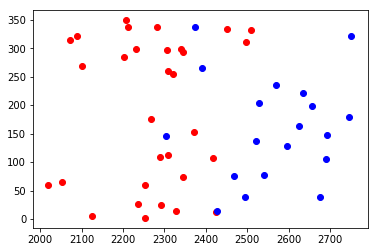

In [11]:
# 2-D experimentation set
Xa, labels = X[:50, 0:2], y[:50]
# Xmin = np.min(Xa)
# Xmax = np.max(Xa)
# Xa = np.divide(Xa - Xmin, Xmax - Xmin)
ya = labels.reshape(-1, 1)
plt.scatter(Xa[labels==1, 0], Xa[labels==1, 1], color='red')
plt.scatter(Xa[labels==0, 0], Xa[labels==0, 1], color='blue')
# Xa = np.array([0.00471885619097257,
# 0.121569120783114,
# 0.186706589684953,
# 0.278369385093796,
# 0.424517590749133,
# 0.543404941790965,
# 0.575093329427250,
# 0.670749084726779,
# 0.825852755105048,
# 0.894776132319904])
# ya = np.array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0]).reshape(-1, 1)

[2382.88  178.52]
[187.51785408 114.83348641]


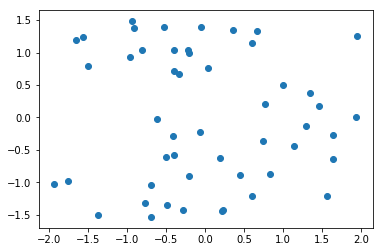

In [12]:
# Data scaling
means = np.mean(Xa, axis=0)
stds = np.std(Xa, axis=0)
print(means)
print(stds)
Xa = (Xa - means) / stds
plt.scatter(Xa[:,0], Xa[:,1])

In [13]:
# Covariance parameters
gamma = 0.1
alpha = 10
N = len(ya)

In [14]:
# Compute covariance for training data.
C = alpha * np.exp(-gamma * l2distance(Xa, Xa))

In [15]:
l2distance(Xa, Xa).shape

(50, 50)

In [16]:
# Newton-Raphson procedure for finding f.
f = np.zeros((N, 1))
invC = np.linalg.pinv(C)

In [17]:
f.shape

(50, 1)

In [18]:
max_its = 10
allf = np.zeros((max_its, N))
allf[0, :] = f.T
for it in range(max_its - 1):
    g = np.divide(1, (1 + np.exp(-f)))
    gradient = np.dot(-invC, f) + ya - g
    hessian = -invC - np.diagflat(g * (1-g))
    f -= np.dot(np.linalg.pinv(hessian), gradient)
    allf[it+1, :] = f.T
hessian = -invC - np.diag(g * (1-g))

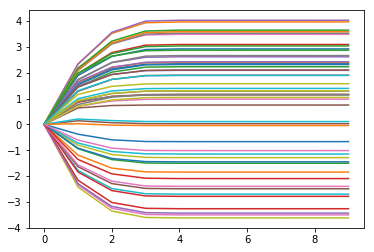

In [19]:
a = plt.plot(allf)

In [55]:
# Predictions with the point estimate
nx, ny = 100, 100
tx, ty = np.linspace(-4.5, 4.5, nx), np.linspace(-4.5, 4.5, ny)
[X, Y] = np.meshgrid(tx, ty)
Ntest = X.shape[0] * X.shape[1]
testx = np.concatenate((X.reshape(Ntest, 1), Y.reshape(Ntest, 1)), axis=1)

In [56]:
# Covariance functions
R = alpha * np.exp(-gamma * l2distance(Xa, testx)**2)
Cstar = alpha * np.exp(-gamma * l2distance(testx, testx)**2)

# Latent function
fs = np.dot(np.dot(R.T, invC), f)

# Mean predictive latent function.
Z = fs.reshape(X.shape)

In [71]:
fs.shape

(10000, 1)

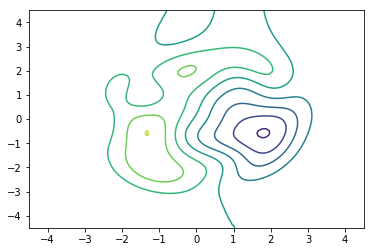

In [74]:
# Contour plot of predictions(function values, NOT probabilities.)
plt.contour(X, Y, Z)

Text(0.5, 1.0, 'Probability Contours')

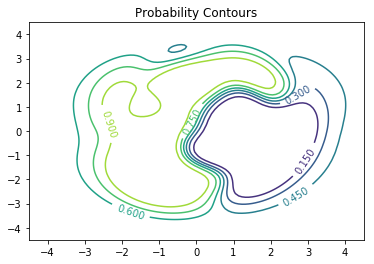

In [79]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, 1/(1 + np.exp(-Z)))
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Probability Contours')